# Pipeline deeplabcut

### La pipeline comprend la création du dataset de training, l'augmentation des données, l'entrainement et la validation et test.

In [1]:
import sys
sys.path.insert(0, r"C:\Users\mcossin\Documents\object_detection\code_detection\DeepLabCut")

In [2]:
import deeplabcut
from deeplabcut.utils import visualization
from deeplabcut.utils import (auxiliaryfunctions, conversioncode)
import os
import pandas as pd
from pathlib import Path
import random
from PIL import Image
from IPython.display import display
from sklearn.model_selection import train_test_split
from pprint import pprint
import time
import matplotlib.pyplot as plt
import pickle
import csv
import numpy as np



Loading DLC 2.3.8...
DLC loaded in light mode; you cannot use any GUI (labeling, relabeling and standalone GUI)


c:\Users\mcossin\.conda\envs\deeplabcut2\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
config_path = r"C:\Users\mcossin\Documents\object_detection\code_detection\keypoint_youtube-sebastien-2024-02-05\config.yaml"

In [4]:
cfg = auxiliaryfunctions.read_config(config_path)

### Afficher les données

In [ ]:
# construit les squellettes avec les labelles dans 'C:/Users/mcossin/Documents/object_detection/code_detection/Keypoint_model-sebastien-2024-01-25/labeled-data'
deeplabcut.check_labels(
    config_path,
    draw_skeleton=True,
)

In [ ]:
def _robust_path_split(path):
    sep = "\\" if "\\" in path else "/"
    splits = path.rsplit(sep, 1)
    if len(splits) == 1:
        parent = "."
        file = splits[0]
    elif len(splits) == 2:
        parent, file = splits
    else:
        raise ("Unknown filepath split for path {}".format(path))
    filename, ext = os.path.splitext(file)
    return parent, filename, ext

In [ ]:
#visualise 2 images 
nb_img = 2

cfg = auxiliaryfunctions.read_config(config_path)
videos = cfg["video_sets"].keys()
video_names = [_robust_path_split(video)[1] for video in videos]

folders_labeled = [
    os.path.join(cfg["project_path"], "labeled-data", str(Path(i))+ '_labeled')
    for i in video_names
]

for folder in folders_labeled :
        length = len(folder)
        print(folder[length - 8:])
        if folder[length - 8:] == '_labeled':
            img_name = os.listdir(folder) # your directory path
            numb_img = len(img_name)
            r = random.sample(range(1, numb_img), nb_img)
            for i in r :
                image = Image.open(os.path.join(folder,img_name[i])) 
                display(image)
            break

### Augmentation des données et création du dataset

##### Changer iteration en fonction du training que l'on veut faire

In [ ]:
deeplabcut.merge_datasets(config_path)

Crée un premier dataset pour rassembler toutes les données et ensuite crée un dataset avec la proportion que je veux

In [ ]:
deeplabcut.create_training_dataset(config_path)

In [ ]:
cfg = auxiliaryfunctions.read_config(config_path)

In [ ]:
trainingsetfolder = auxiliaryfunctions.get_training_set_folder(cfg)

In [ ]:
path_datasets = r"C:\Users\mcossin\Documents\object_detection\code_detection\keypoint_youtube-sebastien-2024-02-05"

path_datasets = os.path.join(path_datasets,trainingsetfolder,r"CollectedData_sebastien.h5")

print(path_datasets)

Crée une liste avec tous les chemin des images

In [ ]:
df = pd.read_hdf(path_datasets)

In [ ]:
image_paths = df.index.to_list()

images_path = []

for element in image_paths:
    path = '/'.join(element)
    images_path.append(path)


In [ ]:
print(images_path)
print("Nombre d'images :",len(images_path))

Crée les splits de train et validation

In [ ]:
#crée les splits d'entrainement et validation
train_images, val_images = train_test_split(images_path, test_size = 0.3, random_state = 1)

In [ ]:
print(train_images)
print(len(train_images))
print(val_images)
print(len(val_images))

Récupere les indices des images pour l entrainement et la validation

In [ ]:
all_indices = list(range(len(images_path)))

train_indices, val_indices = train_test_split(all_indices, test_size=0.3, random_state=1)

In [ ]:
print(train_indices)
print(val_indices)

Ajuste le training fraction pour le chemin d'entrainement

In [ ]:
edit = {
    "TrainingFraction" : [round(len(train_indices) / (len(train_indices) + len(val_indices)),2)]
}
deeplabcut.auxiliaryfunctions.edit_config(
    config_path,
    edit,
)

#### create_training_dataset :Labels from all the extracted frames are merged into a single .h5 file.Only the videos included in the config file are used to create this dataset.



Parameters

config : string
    Full path of the ``config.yaml`` file as a string.

num_shuffles : int, optional, default=1
    Number of shuffles of training dataset to create, i.e. ``[1,2,3]`` for
    ``num_shuffles=3``.

Shuffles: list[int], optional
    Alternatively the user can also give a list of shuffles.

userfeedback: bool, optional, default=False
    If ``False``, all requested train/test splits are created (no matter if they
    already exist). If you want to assure that previous splits etc. are not
    overwritten, set this to ``True`` and you will be asked for each split.

trainIndices: list of lists, optional, default=None
    List of one or multiple lists containing train indexes.
    A list containing two lists of training indexes will produce two splits.

testIndices: list of lists, optional, default=None
    List of one or multiple lists containing test indexes.

net_type: list, optional, default=None
    Type of networks. Currently supported options are

    * ``resnet_50``
    * ``resnet_101``
    * ``resnet_152``
    * ``mobilenet_v2_1.0``
    * ``mobilenet_v2_0.75``
    * ``mobilenet_v2_0.5``
    * ``mobilenet_v2_0.35``
    * ``efficientnet-b0``
    * ``efficientnet-b1``
    * ``efficientnet-b2``
    * ``efficientnet-b3``
    * ``efficientnet-b4``
    * ``efficientnet-b5``
    * ``efficientnet-b6``

augmenter_type: string, optional, default=None
    Type of augmenter. Currently supported augmenters are

    * ``default``
    * ``scalecrop``
    * ``imgaug``
    * ``tensorpack``
    * ``deterministic``

posecfg_template: string, optional, default=None
    Path to a ``pose_cfg.yaml`` file to use as a template for generating the new
    one for the current iteration. Useful if you would like to start with the same
    parameters a previous training iteration. None uses the default
    ``pose_cfg.yaml``.

superanimal_name: string, optional, default=""
    Specify the superanimal name is transfer learning with superanimal is desired. This makes sure the pose config template uses superanimal configs as template


#### creation dataset

In [ ]:
deeplabcut.create_training_dataset(
    config_path,
    trainIndices=[train_indices],
    testIndices=[val_indices],
    net_type="efficientnet-b0",
    augmenter_type = "imgaug"
)

list des augmentations posibles avec imgaug https://imgaug.readthedocs.io/en/latest/source/overview_of_augmenters.html

Lien vers la page de deeplacut avec plus de justification :
#https://deeplabcut.github.io/DeepLabCut/docs/recipes/pose_cfg_file_breakdown.html?highlight=data+augmentation#crop-sampling


In [ ]:
saveiter = 10000
maxiter = 50000


edit = {
    "saveiters": saveiter,
    "maxiters": maxiter
    }

deeplabcut.auxiliaryfunctions.edit_config(
    config_path,
    edit,
)

In [ ]:
train_pose_config, _,_ = deeplabcut.return_train_network_path(config_path)

edit = {
    ################# data augmentation
    "scale_jitter_lo" : 0.5,
    "scale_jitter_up" : 1.25,
    "rotation": 25,
    "fliplr" : True,
    "motion_blur": True,
    "mirror" : False,
    "crop_size": [500,500],
    "cropratio" : 0.4, #That means that there is a 40% the images within the current batch will be cropped
    "max_shift" : 0.4, #which explains the max relative shift to the position of the crop centre. By default is set to 0.4, which means it will be displaced 40% max from the center to not apply identical cropping each time the same image is encountered during training
    "crop_sampling" : 'keypoints', #centre sur un keypoint aleatoirement 
    "sharpening" : True,
    "sharpenratio" : 0.3,          
    ################ hyperparametres
    "batch_size" : 12,  
    "max_input_size" : 1500, 
    "min_input_size" : 64,
    "pos_dist_thresh" : 14,  #default = 14, all locations within this distance threshold are considered positive training samples for detector
    "global_scale" : 1, #The default value is 0.8. It’s the most basic, first scaling that happens to all images in the training queue.
    "pafwidth" : 10,
    "optimizer" :'adam',
    "lr_init": 0.001,
    "multi_step" : [(0.001, 1000), (0.0001, 50000)], #définir les paliers d'apprentissage à différentes étapes de l'entraînement. 
    "alpha_r": 0.02, # vitesse de décroissance du lr
    "decay_steps": 50000, #nombre d'étapes d'apprentissage après lesquelles le taux d'apprentissage doit atteindre son minimum.
    "weight_decay" : 0.0001,
    
    "location_refinement": True, # Determine si calcul de la loss 
    "locref_loss_weight": 1, # pondere l'importance de cette perte par rapport aux autres pertes dans la fonction de perte totale.
    "locref_huber_loss": True, # True: Hubert, False: MSE
    "locref_stdev": 7.2801,

    "partaffinityfield_predict": True, # si paf ou pairwise est true alor calcul de la loss
    "pairwise_predict": True, # Determine si calcul de la loss 
    "pairwise_huber_loss": False, # True: Hubert, False: MSE
    "weigh_only_present_joints" : False,
    "pairwise_loss_weight": 1, # pondere l'importance de cette perte par rapport aux autres pertes dans la fonction de perte totale.

    'weigh_part_predictions': False, #True, #choisit si le poids des prédictions de chaque partie doit être pondéré ou non en fonction de la configuration spécifiée
    'intermediate_supervision': False

}
deeplabcut.auxiliaryfunctions.edit_config(
    train_pose_config,
    edit,
)

In [ ]:
edit = {
    "pcutoff" : 0.7

}
deeplabcut.auxiliaryfunctions.edit_config(
    config_path,
    edit,
)

### Charger un modele checkpoint :

If the user wishes to restart the training at a specific checkpoint they can specify the full path of the checkpoint to the variable init_weights

le fichier checkpoint dans train contient model_checkpoint_path qu est est le chemin vers les checkpoints du model qui a été entrainé

In [ ]:
train_pose_config, _,_ = deeplabcut.return_train_network_path(config_path)

edit = {
    "init_weights" : r"C:\\Users\\mcossin\\Documents\\object_detection\\code_detection\\keypoint_youtube-sebastien-2024-02-05\\dlc-models\\iteration-22\\keypoint_youtubeFeb5-trainset70shuffle1\\train\\snapshot-2000"
    }
deeplabcut.auxiliaryfunctions.edit_config(
    train_pose_config,
    edit,
)

In [ ]:
deeplabcut.DownSampleVideo

### Entrainer un modele

#### train_networks : Trains the network with the labels in the training dataset.


Parameters :

config : string
    Full path of the config.yaml file as a string.

shuffle: int, optional, default=1
    Integer value specifying the shuffle index to select for training.

trainingsetindex: int, optional, default=0
    Integer specifying which TrainingsetFraction to use.
    Note that TrainingFraction is a list in config.yaml.

max_snapshots_to_keep: int or None
    Sets how many snapshots are kept, i.e. states of the trained network. Every
    saving iteration many times a snapshot is stored, however only the last
    ``max_snapshots_to_keep`` many are kept! If you change this to None, then all
    are kept.
    See: https://github.com/DeepLabCut/DeepLabCut/issues/8#issuecomment-387404835

displayiters: optional, default=None
    This variable is actually set in ``pose_config.yaml``. However, you can
    overwrite it with this hack. Don't use this regularly, just if you are too lazy
    to dig out the ``pose_config.yaml`` file for the corresponding project. If
    ``None``, the value from there is used, otherwise it is overwritten!

saveiters: optional, default=None
    This variable is actually set in ``pose_config.yaml``. However, you can
    overwrite it with this hack. Don't use this regularly, just if you are too lazy
    to dig out the ``pose_config.yaml`` file for the corresponding project.
    If ``None``, the value from there is used, otherwise it is overwritten!

maxiters: optional, default=None
    This variable is actually set in ``pose_config.yaml``. However, you can
    overwrite it with this hack. Don't use this regularly, just if you are too lazy
    to dig out the ``pose_config.yaml`` file for the corresponding project.
    If ``None``, the value from there is used, otherwise it is overwritten!

allow_growth: bool, optional, default=True.
    For some smaller GPUs the memory issues happen. If ``True``, the memory
    allocator does not pre-allocate the entire specified GPU memory region, instead
    starting small and growing as needed.
    See issue: https://forum.image.sc/t/how-to-stop-running-out-of-vram/30551/2

gputouse: optional, default=None
    Natural number indicating the number of your GPU (see number in nvidia-smi).
    If you do not have a GPU put None.
    See: https://nvidia.custhelp.com/app/answers/detail/a_id/3751/~/useful-nvidia-smi-queries

autotune: bool, optional, default=False
    Property of TensorFlow, somehow faster if ``False``
    (as Eldar found out, see https://github.com/tensorflow/tensorflow/issues/13317).

keepdeconvweights: bool, optional, default=True
    Also restores the weights of the deconvolution layers (and the backbone) when
    training from a snapshot. Note that if you change the number of bodyparts, you
    need to set this to false for re-training.

modelprefix: str, optional, default=""
    Directory containing the deeplabcut models to use when evaluating the network.
    By default, the models are assumed to exist in the project folder.

superanimal_name: str, optional, default =""
    Specified if transfer learning with superanimal is desired

superanimal_transfer_learning: bool, optional, default = False.
    If set true, the training is transfer learning (new decoding layer). If set false,and superanimal_name is True, then the training is fine-tuning (reusing the decoding layer)

#### start training

In [ ]:
gpu_to_use = 0

start = time.time()
deeplabcut.train_network(
    config_path,
    gputouse=gpu_to_use,
    trainingsetindex=0,
    max_snapshots_to_keep=10,
    autotune=False, 
    displayiters=10,
    saveiters=saveiter,
    maxiters=maxiter,
    allow_growth=True
    #keepdeconvweights=False,#pour charger un modele
)
end = time.time()

training_time = end-start

##### Afficher loss

In [12]:
path_loss = r"C:\Users\mcossin\Documents\object_detection\code_detection\keypoint_youtube-sebastien-2024-02-05\dlc-models\iteration-"

path_loss = path_loss + str(cfg['iteration'])
path_loss = os.path.join(path_loss,r"keypoint_youtubeFeb5-trainset70shuffle1\train\learning_stats.csv")

df_loss = pd.read_csv(path_loss,header = None, delimiter = " ")
print(path_loss)

C:\Users\mcossin\Documents\object_detection\code_detection\keypoint_youtube-sebastien-2024-02-05\dlc-models\iteration-25\keypoint_youtubeFeb5-trainset70shuffle1\train\learning_stats.csv


In [13]:
df_loss = df_loss.replace(',', '', regex=True)

columns_to_drop = [0, 2, 4, 5, 7, 8, 10, 11, 13]

nouvelles_colonnes = {
    1: 'iteration',
    3: 'loss',
    6: 'scmap_loss',
    9: 'locref_loss',
    12: 'limb_loss',
    14: 'lr'
}

df_loss = df_loss.drop(columns=columns_to_drop)
df_loss = df_loss.rename(columns=nouvelles_colonnes)
df_loss = df_loss.astype(float)

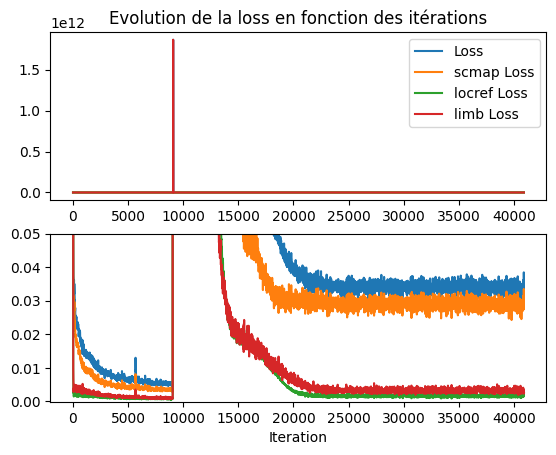

In [14]:
iteration = df_loss['iteration']

loss_fin =  df_loss[df_loss['iteration'] >= 0]
iteration_fin = loss_fin['iteration']

fig, axs = plt.subplots(2)

axs[0].plot(iteration, df_loss['loss'], label='Loss', linestyle='-')
axs[0].plot(iteration, df_loss['scmap_loss'], label='scmap Loss', linestyle='-')
axs[0].plot(iteration, df_loss['locref_loss'], label='locref Loss', linestyle='-')
axs[0].plot(iteration, df_loss['limb_loss'], label='limb Loss', linestyle='-')

axs[1].plot(iteration_fin, loss_fin['loss'], label='Loss', linestyle='-')
axs[1].plot(iteration_fin, loss_fin['scmap_loss'], label='scmap Loss', linestyle='-')
axs[1].plot(iteration_fin, loss_fin['locref_loss'], label='locref Loss', linestyle='-')
axs[1].plot(iteration_fin, loss_fin['limb_loss'], label='limb Loss', linestyle='-')

axs[0].legend()

plt.xlabel('Iteration')

axs[0].set_title('Evolution de la loss en fonction des itérations')

plt.ylim(-1e-4, 5e-2)

plt.show()

### Evaluer un modele

Running  DLC_effnet_b0_keypoint_youtubeFeb5shuffle1_20000  with # of trainingiterations: 20000


c:\Users\mcossin\.conda\envs\deeplabcut2\lib\site-packages\tensorflow\python\keras\engine\base_layer_v1.py:1697: UserWarning: `layer.apply` is deprecated and will be removed in a future version. Please use `layer.__call__` method instead.
  warnings.warn('`layer.apply` is deprecated and '


Activating extracting of PAFs
Network Evaluation underway...


0it [00:00, ?it/s]C:\Users\mcossin\Documents\object_detection\code_detection\DeepLabCut\deeplabcut\pose_estimation_tensorflow\core\evaluate_multianimal.py:379: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  temp["bodyparts"].replace(
C:\Users\mcossin\Documents\object_detection\code_detection\DeepLabCut\deeplabcut\pose_estimation_tensorflow\core\evaluate_multianimal.py:379: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.i

Results for 20000 training iterations, training fraction of 70, and shuffle 1:
Train error: nan pixels. Test error: nan pixels.
With pcutoff of 0.7:
Train error: nan pixels. Test error: nan pixels.
##########################################
Average Euclidean distance to GT per individual (in pixels; test-only)
individuals
club1   NaN
club2   NaN
club3   NaN
Average Euclidean distance to GT per bodypart (in pixels; test-only)
bodyparts
clubhandle   NaN
clubhead     NaN
clubmiddle   NaN
Done and results stored for snapshot:  snapshot-20000
Selecting best skeleton...
3
3


IndexError: list index out of range

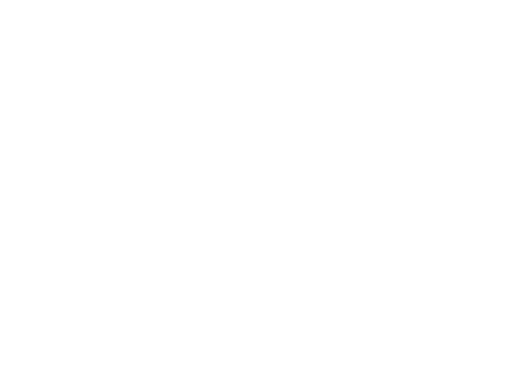

In [7]:
#pd.set_option('future.no_silent_downcasting', True)

deeplabcut.evaluate_network(
    config_path,
    plotting='bodypart', 
    show_errors = True, #Display train and test errors.
    gputouse = 0,
    rescale = 'global_scale',
    per_keypoint_evaluation = True,
)

In [11]:
cfg = auxiliaryfunctions.read_config(config_path)

In [ ]:
evaluationfolder = os.path.join(
                cfg["project_path"],
                str(
                    auxiliaryfunctions.get_evaluation_folder(
                        0.7, 1, cfg, modelprefix=""
                    )
                ),
            )

In [ ]:
np.set_printoptions(threshold=np.inf)

In [ ]:
print(evaluationfolder)

In [ ]:
results_file = os.path.join(evaluationfolder,"results.pickle")
with open(results_file, 'rb') as fichier:
    data = pickle.load(fichier)

print(results_file)
print(data[2][0][1].keys())
print(data[2][0][0]['all recalls'])


In [ ]:
all_matched_train = data[2][0][0]['all_matched']
all_matched_test = data[2][1][0]['all_matched']

In [ ]:
conf_pred_train = np.asarray([match[0].confidence for match in all_matched_train])
conf_pred_test = np.asarray([match[0].confidence for match in all_matched_test])

af_pred_train = np.asarray([match[0].affinity for match in all_matched_train])
af_pred_test = np.asarray([match[0].affinity for match in all_matched_test])

In [ ]:
print(af_pred_test)

In [ ]:
idx_train = np.argsort(-conf_pred_train, kind="mergesort")
idx_test = np.argsort(-conf_pred_test, kind="mergesort")

In [ ]:
oks_train = np.asarray([match[2] for match in all_matched_train])[idx_train]    
oks_test = np.asarray([match[2] for match in all_matched_test])[idx_test]

In [ ]:
plt.scatter(conf_pred_test, oks_test, c='blue', label='Vrais positifs')
plt.xlabel('Affinité des prédictions')
plt.ylabel('Seuil OKS')
plt.title('Affinité des prédictions en fonction du seuil OKS')
plt.legend()
plt.show()

In [ ]:
plt.scatter(af_pred_test, oks_test, c='blue', label='Vrais positifs')
plt.xlabel('Affinité des prédictions')
plt.ylabel('Seuil OKS')
plt.title('Affinité des prédictions en fonction du seuil OKS')
plt.legend()
plt.show()

##### Tresholds du oks :

In [ ]:
oks_thresholds=np.linspace(0.5, 0.95, 10)
print(oks_thresholds)

In [ ]:
oks_ind = 1

In [ ]:
precision_train_values = [d[0]["all precisions"] for d in data[2]]
recall_train_values = [d[0]["all recalls"] for d in data[2]]
precision_test_values = [d[1]["all precisions"] for d in data[2]]
recall_test_values = [d[1]["all recalls"] for d in data[2]]

On obtient pour precision, les précisions selon les 2 graphs [0] et [1], selon les oks de [0] a [9] et selon les seuls de recall de 0 a 100 

On obtient pour le recall, les recalls selon les 2 graphs [0] et [1], selon les oks de [0] a [9] 

In [ ]:
recall_test_values

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)


print(precision_test_values[1])

In [ ]:
recall_test_values

##### maP et maR calculé avec un seuil entre 0.5 et 0.95.

2 et 3 correspondent aux graph et 1 et 2 respictivement la liaison [0,2] et [0,2,1]

##### unaugmented data

In [ ]:
map_file = os.path.join(evaluationfolder, "DLC_effnet_b0_keypoint_youtubeFeb5shuffle1_2000-snapshot-2000_map.pickle")
with open(map_file, 'rb') as fichier:
    results_mean = pickle.load(fichier)

pprint(results_mean)

In [ ]:
ind = random.sample(range(len(images_path)-1), 10)

deeplabcut.extract_save_all_maps(
    config_path, 
    shuffle=1,
    gputouse=1,
    Indices= ind
    )

Pour reconstruire une video avec les prédictions :

In [ ]:
#chemin de la vidéo choisit a analyser
video_path = r"C:\Users\mcossin\Documents\object_detection\Data\youtube_video\video-youtube-1_test.mp4" #os.path.join(video_folder_path, video) 

In [ ]:
dest = r"C:\Users\mcossin\Documents\object_detection\code_detection\keypoint_youtube-sebastien-2024-02-05\dlc-models\iteration-"
iteration = cfg['iteration']

dest = dest + str(iteration)
dest = os.path.join(dest,'keypoint_youtubeFeb5-trainset70shuffle1/test')
print(dest)

In [ ]:
deeplabcut.analyze_videos(config_path,[video_path], videotype='.mp4', auto_track=True,destfolder=dest)

In [ ]:
deeplabcut.create_video_with_all_detections(config_path, [video_path], videotype='.mp4', destfolder= dest)

### Rafinage des données et ajout de données

Analyse toutes les vidéos pour rafiner les données

In [ ]:
video_folder_path = r"C:\Users\mcossin\Documents\object_detection\code_detection\keypoint_youtube-sebastien-2024-02-05\videos"
video_folder = os.listdir(video_folder_path)

for video in video_folder:

    video_path = os.path.join(video_folder_path, video) 
    
    labeled_data_folder =r"C:\Users\mcossin\Documents\object_detection\code_detection\keypoint_youtube-sebastien-2024-02-05\labeled-data"
    
    dest = os.path.join(labeled_data_folder,video[:-4])
    
    deeplabcut.analyze_videos(config_path,[video_path], videotype='.mp4',destfolder = dest)
    

Exctration des frames outliers 

In [ ]:
video_folder_path = r"C:\Users\mcossin\Documents\object_detection\code_detection\Keypoint_youtube-sebastien-2024-02-05\videos"
video_folder = os.listdir(video_folder_path)

for video in video_folder:
    
    video_path = os.path.join(video_folder_path, video) 
    
    labeled_data_folder =r"C:\Users\mcossin\Documents\object_detection\code_detection\Keypoint_youtube-sebastien-2024-02-05\labeled-data"
    
    dest = os.path.join(labeled_data_folder,video[:-4])
    
    files = os.listdir(dest)
    print(files)
    for file in files:
        if file.endswith('_full.pickle'):
            pickle = file

    pickle_path= os.path.join(dest,pickle)
    
    deeplabcut.find_outliers_in_raw_data(config_path, pickle_path,video_path)

In [ ]:
deeplabcut.label_frames(config_path)

In [ ]:
deeplabcut.utils.plot_edge_affinity_distributions(r"C:\Users\mcossin\Documents\object_detection\code_detection\Keypoint_model-sebastien-2024-01-25\evaluation-results\iteration-0\Keypoint_modelJan25-trainset70shuffle1\DLC_effnet_b0_Keypoint_modelJan25shuffle1_10000-snapshot-10000_full.pickle")